In [69]:
import pandas as pd
import seaborn as sns
import plotly.express as px

# check xgboost version
import xgboost
from xgboost import XGBRegressor
print(xgboost.__version__)

from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_squared_log_error

import numpy as np
import mlflow

import shap

1.6.2


In [57]:
# !pip install openpyxl

In [70]:
FILE = r"D:\Documents\Masters\IITGNX - Energy Policy and Regulation\Capstone Project\Sector Coupling Tool\ML\ML\RA_data_220816.xlsx"

In [71]:
df = pd.read_excel(FILE, engine="openpyxl")

In [72]:
df.head()

,Case ID,LCOS - exc ore,-,-.1,-.2,-.3,-.4,RE $,installation year,mean hourly solar CF,...,CoV hourly solar CF,mean monthly solar CF,median monthly solar CF,CoV monthly solar CF,mean hourly wind CF,median hourly wind CF,CoV hourly wind CF,mean monthly wind CF,median monthly wind CF,CoV monthly wind CF
0,[RE 2015] 10a-2030-S1,524.60,0,0,0,0,0,172.38,2030,0.233697,...,1.217013,170.599125,170.0625,0.095728,0.364058,0.3400,0.653778,265.762583,271.9295,0.105940
1,[RE 2015] 10a-2040-S1,474.97,0,0,0,0,0,140.51,2040,0.233697,...,1.217013,170.599125,170.0625,0.095728,0.364058,0.3400,0.653778,265.762583,271.9295,0.105940
2,[RE 2015] 10a-2050-S1,427.39,0,0,0,0,0,106.22,2050,0.233697,...,1.217013,170.599125,170.0625,0.095728,0.364058,0.3400,0.653778,265.762583,271.9295,0.105940
3,[RE 2015] 10b-2030-S1,573.05,0,0,0,0,0,174.64,2030,0.287160,...,1.163242,209.627000,213.2700,0.135638,0.309230,0.2445,0.838967,225.737750,230.8125,0.104209
4,[RE 2015] 10b-2040-S1,511.96,0,0,0,0,0,137.21,2040,0.287160,...,1.163242,209.627000,213.2700,0.135638,0.309230,0.2445,0.838967,225.737750,230.8125,0.104209


In [16]:
# float_columns = [c for c in df.columns if df[c].dtype=="float"]
# df[float_columns].describe()

In [73]:
float_columns = [c for c in df.columns if df[c].dtype=="float"]
for col in float_columns:
    print("========")
    print(col)
    print(df[col].describe())

LCOS - exc ore
count     675.000000
mean      551.429822
std        98.165077
min       394.520000
25%       481.995000
50%       531.310000
75%       598.265000
max      1134.550000
Name: LCOS - exc ore, dtype: float64
RE $
count    675.000000
mean     164.376519
std       54.512213
min       59.970000
25%      123.625000
50%      155.980000
75%      195.380000
max      365.210000
Name: RE $, dtype: float64
mean hourly solar CF
count    675.000000
mean       0.207552
std        0.054271
min        0.101277
25%        0.171174
50%        0.204847
75%        0.245419
max        0.322894
Name: mean hourly solar CF, dtype: float64
median hourly solar CF
count    675.000000
mean       0.011733
std        0.011278
min        0.000000
25%        0.003500
50%        0.008397
75%        0.016000
max        0.084000
Name: median hourly solar CF, dtype: float64
CoV hourly solar CF
count    675.000000
mean       1.332418
std        0.159571
min        1.103510
25%        1.229988
50%        1.284

In [74]:
df.isnull().sum()/len(df)

Case ID                    0.0
LCOS - exc ore             0.0
-                          0.0
-.1                        0.0
-.2                        0.0
-.3                        0.0
-.4                        0.0
RE $                       0.0
installation year          0.0
mean hourly solar CF       0.0
median hourly solar CF     0.0
CoV hourly solar CF        0.0
mean monthly solar CF      0.0
median monthly solar CF    0.0
CoV monthly solar CF       0.0
mean hourly wind CF        0.0
median hourly wind CF      0.0
CoV hourly wind CF         0.0
mean monthly wind CF       0.0
median monthly wind CF     0.0
CoV monthly wind CF        0.0
dtype: float64

In [75]:
df.corr()["LCOS - exc ore"].sort_values(ascending=False)

LCOS - exc ore             1.000000
RE $                       0.915252
CoV monthly solar CF       0.547460
CoV hourly solar CF        0.536652
CoV monthly wind CF        0.315289
CoV hourly wind CF         0.224341
median hourly solar CF    -0.308265
mean hourly wind CF       -0.320471
mean monthly wind CF      -0.320471
median monthly wind CF    -0.330536
median hourly wind CF     -0.370889
installation year         -0.494740
mean hourly solar CF      -0.551875
mean monthly solar CF     -0.551876
median monthly solar CF   -0.552996
-                               NaN
-.1                             NaN
-.2                             NaN
-.3                             NaN
-.4                             NaN
Name: LCOS - exc ore, dtype: float64

In [76]:
features = [
#     "RE $",
#     "CoV monthly solar CF",
    "CoV hourly solar CF",
#     "CoV monthly wind CF",
    "CoV hourly wind CF",
    "median hourly solar CF",
    "median hourly wind CF",
#     "mean hourly solar CF",
#     "mean hourly wind CF"
]

target = ["LCOS - exc ore"]

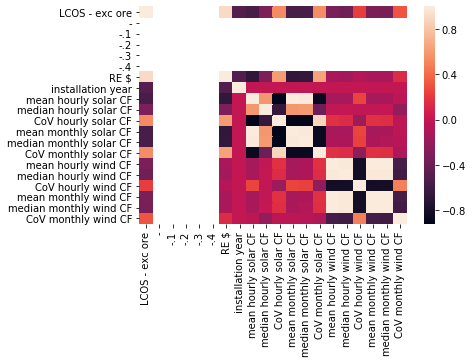

In [77]:
sns.heatmap(df.corr())

In [78]:
df.corr()["LCOS - exc ore"].sort_values(ascending=False)

LCOS - exc ore             1.000000
RE $                       0.915252
CoV monthly solar CF       0.547460
CoV hourly solar CF        0.536652
CoV monthly wind CF        0.315289
CoV hourly wind CF         0.224341
median hourly solar CF    -0.308265
mean hourly wind CF       -0.320471
mean monthly wind CF      -0.320471
median monthly wind CF    -0.330536
median hourly wind CF     -0.370889
installation year         -0.494740
mean hourly solar CF      -0.551875
mean monthly solar CF     -0.551876
median monthly solar CF   -0.552996
-                               NaN
-.1                             NaN
-.2                             NaN
-.3                             NaN
-.4                             NaN
Name: LCOS - exc ore, dtype: float64

In [79]:
?xgboost.XGBRegressor

Init signature:
xgboost.XGBRegressor(
    *,
    objective: Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'reg:squarederror',
    **kwargs: Any,
) -> None
Docstring:     
Implementation of the scikit-learn API for XGBoost regression.


Parameters
----------

    n_estimators : int
        Number of gradient boosted trees.  Equivalent to number of boosting
        rounds.

    max_depth :  Optional[int]
        Maximum tree depth for base learners.
    max_leaves :
        Maximum number of leaves; 0 indicates no limit.
    max_bin :
        If using histogram-based algorithm, maximum number of bins per feature
    grow_policy :
        Tree growing policy. 0: favor splitting at nodes closest to the node, i.e. grow
        depth-wise. 1: favor splitting at nodes with highest loss change.
    learning_rate : Optional[float]
        Boosting learning rate (xgb's "eta")
    verbosity : Optional[int]
        The degree of verbosity. Va

63036642c1d7472cb5c3857bfe981f9b
train set size: (540, 4)
test set size: (135, 4)
r2_test 0.6818260777128539
r2_train 0.7104387846811004
rmse_test 0.10878444812084613
rmse_train 0.09128166838981706
Best parameters: {'grow_policy': 'depthwise', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 0.1, 'n_estimators': 50}


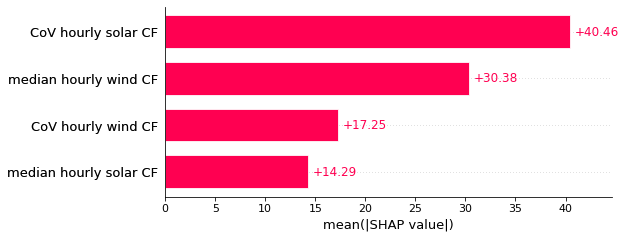

In [80]:
with mlflow.start_run(run_name="LCOS x Green Hydrogen ML Model_v4"):
    run = mlflow.active_run()
    run_id = run.info.run_id
    print(run_id)
    RANDOM_STATE = 21
    
#     df[f"{target}_original"] = df[target]
#     df[target] = np.log(df[target])
    
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
    print("train set size:", X_train.shape)
    print("test set size:", X_test.shape)
    
    param_grid = {
        'max_depth': [3, 5, 7, 9],
        'learning_rate': [0.1, 0.01, 0.05],
        'n_estimators': [50, 100, 200, 300],
        'min_child_weight': [0.1, 0.5],
        'grow_policy':['depthwise','lossguide']
        
    }
    

    model = XGBRegressor(seed=RANDOM_STATE)

    kf = KFold(n_splits = 5, random_state = RANDOM_STATE, shuffle=True)
    scorer = make_scorer(mean_squared_error, greater_is_better=False)
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    predictions = grid_search.predict(X_test)
    predictions_train = grid_search.predict(X_train)
    
    r2_test  = r2_score(y_test.values.reshape(-1,1), predictions.reshape(-1,1))
    r2_train = r2_score(y_train.values.reshape(-1,1), predictions_train.reshape(-1,1))
    
    rmse_test  = np.sqrt(mean_squared_log_error(y_test.values.reshape(-1,1), predictions.reshape(-1,1)))
    rmse_train = np.sqrt(mean_squared_log_error(y_train.values.reshape(-1,1), predictions_train.reshape(-1,1)))
    
    print("r2_test", r2_test)
    print("r2_train", r2_train)
    print("rmse_test", rmse_test)
    print("rmse_train", rmse_train)
    print(f"Best parameters: {grid_search.best_params_}")
    
    mlflow.log_param("r2_test", r2_test)
    mlflow.log_param("r2_train", r2_train)
    mlflow.log_param("rmse_test", rmse_test)
    mlflow.log_param("rmse_train", rmse_train)
    mlflow.log_param("param_grid", str(param_grid))
    mlflow.log_param("best_params", str(grid_search.best_params_))
    
    mdl_path = "xgboost_mdl"
    mlflow.xgboost.log_model(grid_search.best_estimator_, mdl_path)
    
    explainer = shap.Explainer(grid_search.predict, X_test)
    shap_values = explainer(X_test)
    shap.plots.bar(shap_values)




In [66]:
# Load saved model
loaded_model = XGBRegressor()
loaded_model.load_model('best_model.ubj')

# Use loaded model for predictions
predictions = loaded_model.predict(X_test)
predictions_train = loaded_model.predict(X_train)

In [67]:
predictions.reshape(-1,1)

array([[522.6815 ],
       [533.584  ],
       [680.9497 ],
       [454.3388 ],
       [436.30713],
       [592.04706],
       [479.4338 ],
       [729.09827],
       [603.834  ],
       [575.27734],
       [517.753  ],
       [456.06836],
       [581.4277 ],
       [514.5012 ],
       [587.1471 ],
       [433.67828],
       [536.24896],
       [436.74854],
       [694.657  ],
       [523.1353 ],
       [649.1692 ],
       [459.50043],
       [438.27597],
       [480.79037],
       [451.12903],
       [578.6298 ],
       [619.79297],
       [554.1425 ],
       [484.96243],
       [522.11835],
       [541.0253 ],
       [660.7182 ],
       [551.1981 ],
       [591.32733],
       [460.32275],
       [573.00165],
       [914.66486],
       [497.65887],
       [552.8659 ],
       [565.71826],
       [465.32706],
       [466.28494],
       [446.0685 ],
       [745.3356 ],
       [480.95895],
       [779.03253],
       [474.99744],
       [695.3721 ],
       [623.92645],
       [490.49042],


In [68]:
y_test.values.reshape(-1,1)

array([[ 523.16],
       [ 533.41],
       [ 698.1 ],
       [ 455.28],
       [ 424.31],
       [ 588.71],
       [ 483.56],
       [ 635.86],
       [ 583.6 ],
       [ 574.79],
       [ 521.16],
       [ 459.73],
       [ 571.6 ],
       [ 507.2 ],
       [ 561.46],
       [ 442.2 ],
       [ 539.38],
       [ 420.11],
       [ 715.93],
       [ 530.63],
       [ 677.15],
       [ 458.98],
       [ 440.73],
       [ 484.9 ],
       [ 453.31],
       [ 584.46],
       [ 612.47],
       [ 536.98],
       [ 476.92],
       [ 519.77],
       [ 546.48],
       [ 661.54],
       [ 589.07],
       [ 583.41],
       [ 447.9 ],
       [ 598.25],
       [ 970.29],
       [ 500.95],
       [ 544.17],
       [ 568.79],
       [ 483.61],
       [ 473.72],
       [ 429.73],
       [ 655.01],
       [ 460.04],
       [ 726.42],
       [ 488.47],
       [ 731.04],
       [ 613.12],
       [ 488.02],
       [ 687.09],
       [ 666.91],
       [ 515.92],
       [ 522.93],
       [ 470.55],
       [ 9

In [69]:
r2_score(y_test.values.reshape(-1,1), predictions.reshape(-1,1))

0.9586065940856939

In [70]:
r2_score(y_train.values.reshape(-1,1), predictions_train.reshape(-1,1))

0.9998158847842658

In [71]:
np.sqrt(mean_squared_log_error(y_test.values.reshape(-1,1), predictions.reshape(-1,1)))

0.0329858396366499

In [72]:
np.sqrt(mean_squared_log_error(y_train.values.reshape(-1,1), predictions_train.reshape(-1,1)))

0.0023624862543979125

In [ ]:
px.line()